In [35]:
import os
import matplotlib.pyplot as plt
import numpy as np
import random
import copy
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from torch.optim.lr_scheduler import _LRScheduler

import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torchsummary import summary

from sklearn import manifold
from torchvision.datasets import VisionDataset, Flickr30k
from collections import Counter
import pickle
from tqdm import tqdm
import nltk
from collections import defaultdict
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from nltk.corpus import stopwords


In [2]:
!pip install torchsummary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
!pip install --user -U nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 377, in run
    requirement_set = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/resolution/resolvelib/resolver.py", line 92, in resolve
    result = self._result = resolver.resolve(
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 546, in resolve
    state = resolution.resolve(requirements, max_rounds=max_rounds)
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/resolvelib/resolvers.py", line 397, in 

In [4]:
!pip install tqdm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install -U scikit-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip3 install torch torchvision

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [8]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [9]:
%%shell
tar -xvzf /content/drive/MyDrive/flickr30k-images.tar.gz

Streaming output truncated to the last 5000 lines.
flickr30k-images/5354904685.jpg
flickr30k-images/5354911151.jpg
flickr30k-images/535529555.jpg
flickr30k-images/5356236664.jpg
flickr30k-images/5356318668.jpg
flickr30k-images/535830521.jpg
flickr30k-images/5359437945.jpg
flickr30k-images/5361355399.jpg
flickr30k-images/53614287.jpg
flickr30k-images/536147209.jpg
flickr30k-images/5361551308.jpg
flickr30k-images/536156200.jpg
flickr30k-images/5362687336.jpg
flickr30k-images/5363528971.jpg
flickr30k-images/5363903246.jpg
flickr30k-images/5364849864.jpg
flickr30k-images/536495604.jpg
flickr30k-images/5365075444.jpg
flickr30k-images/536533294.jpg
flickr30k-images/536537638.jpg
flickr30k-images/5366770416.jpg
flickr30k-images/536718060.jpg
flickr30k-images/536721406.jpg
flickr30k-images/5367322642.jpg
flickr30k-images/536739751.jpg
flickr30k-images/536828916.jpg
flickr30k-images/536904709.jpg
flickr30k-images/5369771639.jpg
flickr30k-images/5370581509.jpg
flickr30k-images/537069478.jpg
flic

In [10]:
training_data = Flickr30k('flickr30k-images', 'results_20130124.token')

In [11]:
class Vocabulary(object):
    """Simple vocabulary wrapper."""
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        self.all_words = []

    def add_word(self, word):
        if not word in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1
            self.all_words.append(word)
            
    def __call__(self, word):
        if not word in self.word2idx:
            return self.word2idx['<unk>']
        return self.word2idx[word]

    def __len__(self):
        return len(self.word2idx)

    def get_id(self, w):
        return self.word2idx[w]

    def encode_seq(self, l):
        return [self.word2idx[i] if i in self.word2idx else self.word2idx['<unk>'] for i in l]

    def get_token(self, idx):
        return self.idx2word[idx]

    def decode_seq(self, l):
        return [self.idx2word[i] for i in l] 

In [12]:
def get_splits(filepath = 'flickr30k-images', size = 256, seed = 2020):
    np.random.seed(seed)
    train_set = set()
    val_set = set()
    test_set = set()
    
    for filename in tqdm(os.listdir(filepath)):
        if filename[-3:] == 'jpg':
            img = np.array(Image.open(os.path.join(filepath, filename)))
            if img.shape[0] >= size and img.shape[1] >= size:
                selector = np.random.multinomial(size=1, n=1, pvals = [0.8, 0.1, 0.1])
                if selector[0][0] == 1:
                    train_set.add(filename)
                elif selector[0][1] == 1: 
                    val_set.add(filename)
                else:
                    test_set.add(filename)
            
    pickle.dump(train_set,open('train_set.p', 'wb'))
    pickle.dump(val_set,open('val_set.p', 'wb'))
    pickle.dump(test_set,open('test_set.p', 'wb'))

get_splits()


100%|██████████| 31784/31784 [03:02<00:00, 173.88it/s]


In [13]:
def build_vocab(ann_file = 'results_20130124.token', threshold = 3):
    """Build a simple vocabulary wrapper."""
    punc_set = set([',',';',':','.','?','!','(',')','``','"'])
    counter = Counter()
    caption_list = []
    split = pickle.load(open('train_set.p', 'rb'))
    ann_file = os.path.expanduser(ann_file)
    with open(ann_file) as fh:
        for line in fh:
            img, caption = line.strip().split('\t')
            if img[:-2] in split:
                caption_list.append(caption)
    for caption in tqdm(caption_list):
        tokens = nltk.tokenize.word_tokenize(caption.lower())
        tokens = [elem for elem in tokens if elem not in punc_set] 
        counter.update(tokens)

    words = [word for word, cnt in counter.items() if cnt >= threshold] 

    vocab = Vocabulary()
    vocab.add_word('<pad>')
    vocab.add_word('<start>')
    vocab.add_word('<end>')
    vocab.add_word('<unk>')
    vocab.add_word('<break>')

    for i, word in enumerate(words):
        vocab.add_word(word)
    return vocab

In [14]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [15]:
vocab = build_vocab()
pickle.dump(vocab,open('vocab.p', 'wb'))

100%|██████████| 126330/126330 [00:12<00:00, 9930.98it/s]


In [16]:
class Custom_Flickr30k(VisionDataset):

    def __init__(self, root, ann_file, vocabulary, train=True, transform=None, target_transform=None, test=False):
        super(Custom_Flickr30k, self).__init__(root, transform=transform, target_transform=target_transform)
        self.ann_file = os.path.expanduser(ann_file)
        self.train = train
        self.test = test
        self.annotations = defaultdict(list)
        self.punc_set = set([',',';',':','.','?','!','(',')'])
        
        if self.train:
            split = pickle.load(open('train_set.p', 'rb'))
            idx=0
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        self.annotations[idx].extend([img,caption])
                        idx += 1
            self.ids = np.arange(idx-1)
        elif self.test:
            split = pickle.load(open('test_set.p', 'rb'))
            idx=0
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        self.annotations[idx].extend([img,caption])
                        idx += 1
            self.ids = np.arange(idx-1)
        else:
            split = pickle.load(open('val_set.p', 'rb'))
            idx = -1
            last_image = ''
            with open(self.ann_file) as fh:
                for line in fh:
                    img_id, caption = line.strip().split('\t')
                    img = img_id[:-2]
                    if img in split:
                        if img != last_image:
                            idx += 1
                            last_image = img
                            self.annotations[idx].append(img)
                            self.annotations[idx].append([caption])
                        else:
                            self.annotations[idx][1].append(caption)
            self.ids = np.arange(idx)

    def __getitem__(self, index):
        
        instance = self.annotations[index]
        
        img_id = instance[0]
        caption = instance[1]
        
        filename = os.path.join(self.root, img_id)
        img = Image.open(filename).convert('RGB')
        if self.transform is not None:
            img = self.transform(img)
        
        if self.train or self.test:

            tokens = nltk.tokenize.word_tokenize(str(caption).lower())
            caption = []
            caption.append(vocab('<start>'))
            caption.extend([vocab(token) for token in tokens if token not in self.punc_set])
            caption.append(vocab('<end>'))
            target = torch.Tensor(caption)
            
        else:
            target = []
            for item in caption:
                tokens = nltk.tokenize.word_tokenize(str(item).lower())
                target.extend([vocab(token) for token in tokens if token not in self.punc_set])
                target.append(vocab('<break>'))
            
            target = torch.Tensor(target[:-1])

        return img, target


    def __len__(self):
        return len(self.ids)

In [17]:
def collate_fn(data):

    data.sort(key=lambda x: len(x[1]), reverse=True)
    images, captions = zip(*data)

    images = torch.stack(images, 0)

    lengths = [len(cap) for cap in captions]
    targets = torch.zeros(len(captions), max(lengths)).long()
    for i, cap in enumerate(captions):
        end = lengths[i]
        targets[i, :end] = cap[:end]        
    return images, targets, lengths

In [18]:
batch_size = 128
num_workers = 4
crop_size = 256
transform = transforms.Compose([
            transforms.RandomCrop(crop_size),
            transforms.RandomHorizontalFlip(), 
            transforms.ToTensor(), 
            transforms.Normalize((0.444, 0.421, 0.385), 
                                 (0.285, 0.277, 0.286))])

In [19]:
flickr_data = Custom_Flickr30k('flickr30k-images', 'results_20130124.token', vocab, transform=transform)
data_loader = torch.utils.data.DataLoader(dataset=flickr_data, 
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=num_workers,
                                          collate_fn=collate_fn)

In [20]:
class SimpleEncoderCNN(nn.Module):
    def __init__(self, embed_size, fine_tune=False):
        super(SimpleEncoderCNN, self).__init__()
        self.fine_tune = fine_tune
        resnet = models.resnet50(pretrained=True)
        modules = list(resnet.children())[:-1]      
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.1)

    def forward(self, images):
        if self.fine_tune:
            features = self.resnet(images)
        else:
            with torch.no_grad():
                features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features

In [21]:
class SimpleDecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(SimpleDecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)

    def forward(self, features, captions, lengths):
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True)
        hiddens, _ = self.gru(packed)
        outputs = self.linear(hiddens[0])
        return outputs

    def sample(self, features, states=None, max_seq_length=20):
        sampled_ids = []
        inputs = features.unsqueeze(1)
        for i in range(max_seq_length):
            hiddens, states = self.gru(inputs, states)         
            outputs = self.linear(hiddens.squeeze(1))            
            _, predicted = outputs.max(1)                       
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       
            inputs = inputs.unsqueeze(1)                        
        sampled_ids = torch.stack(sampled_ids, 1)                
        return sampled_ids

In [22]:
crop_size=256
val_transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])
val_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('flickr30k-images','results_20130124.token', vocab, transform=val_transform, train=False),
            batch_size=16,
            shuffle=False,
            num_workers=2,
            collate_fn=collate_fn)

In [23]:
embed_size = 512
hidden_size = 1024
num_layers = 1
learning_rate = 1e-4
num_epoch = 10
fine_tune = False
max_BLEU = 0
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

encoder = SimpleEncoderCNN(embed_size, fine_tune).to(device)
decoder = SimpleDecoderRNN(embed_size, hidden_size, len(vocab), num_layers).to(device)


criterion = torch.nn.CrossEntropyLoss()
if fine_tune:
    params = list(encoder.parameters()) + list(decoder.parameters())
else:
    params = list(decoder.parameters()) + list(encoder.linear.parameters()) + list(encoder.bn.parameters())
optimizer = torch.optim.Adam(params, lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [24]:
def bleu_eval(encoder, decoder, data_loader, batch_size, device):
    
    with torch.no_grad():
        features = None
        imgs = None
        caps = None
        encoder.to(device)
        decoder.to(device)
        for i, (images, captions, lengths) in enumerate(data_loader):
            features = encoder(images.to(device))
            imgs = images
            caps = captions
            results = decoder.sample(features)
            true_outputs=[]

            for caption in captions:
                caption = caption.cpu().numpy().astype(str).tolist()
                idx = 0
                curr_img_captions = [[]] 
                for tok in caption[1:-1]:
                    if tok == '4': 
                        idx += 1
                        curr_img_captions.append([])
                    elif tok != '0':
                        curr_img_captions[idx].append(vocab.idx2word[int(tok)])
                true_outputs.append(curr_img_captions)

            predictions = []
            for pred in results:
                curr = []
                for tok in pred:
                    if tok == '2': 
                        break
                    curr.append(vocab.idx2word[int(tok)])
                predicted_caption = []
                for token_index in curr:
                    if token_index == '<end>':
                        break
                    elif token_index == '<start>':
                        continue
                    predicted_caption.append(token_index)
                predictions.append(predicted_caption)

        return nltk.bleu_score.corpus_bleu(true_outputs, predictions, weights=(0.5, 0.5, 0, 0))

In [25]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
train_loss = []
bleu_score = []
print(device)
for epoch in range(num_epoch):
    epoch_loss = 0
    for i, (images, captions, lengths) in tqdm(enumerate(data_loader)):
        
        encoder.train()
        decoder.train()

        images = images.to(device)
        captions = captions.to(device)
        targets = pack_padded_sequence(captions, lengths, batch_first=True)[0]

        features = encoder(images)
        features.to(device)
        outputs = decoder(features, captions, lengths)
        loss = criterion(outputs, targets)
        epoch_loss += loss.item()
        decoder.zero_grad()
        encoder.zero_grad()
        loss.backward()
        optimizer.step()
        
    epoch_loss = epoch_loss/1110
    train_loss.append(epoch_loss)
    
    encoder.eval()
    decoder.eval()
    
    score = bleu_eval(encoder, decoder, val_loader, 16, device)
    bleu_score.append(score)
    is_best = score > max_BLEU
    max_BLEU = max(score, max_BLEU)

    if is_best:
        torch.save(encoder, 'encoder_gru_exp.pt')
        torch.save(decoder, 'decoder_gru_exp.pt')

        
    print('Epoch [{}/{}], Loss: {:.4f}'
              .format(epoch+1, num_epoch, epoch_loss))
    print("Bleu Score: ", score)

cuda


987it [03:51,  4.26it/s]


Epoch [1/10], Loss: 3.6561
Bleu Score:  0.31234752377721214


987it [03:51,  4.25it/s]


Epoch [2/10], Loss: 2.9465
Bleu Score:  0.2482514050071844


/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/usr/local/lib/python3.10/dist-packages/nltk/translate/bleu_score.py:552: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
987it [03:50,  4.28it/s]


Epoch [3/10], Loss: 2.7305
Bleu Score:  0.3084109455753246


987it [03:51,  4.26it/s]


Epoch [4/10], Loss: 2.5910
Bleu Score:  0.27524094128159016


987it [03:50,  4.27it/s]


Epoch [5/10], Loss: 2.4893
Bleu Score:  0.3382550457458691


987it [03:51,  4.26it/s]


Epoch [6/10], Loss: 2.4087
Bleu Score:  0.28991675380690063


987it [03:52,  4.24it/s]


Epoch [7/10], Loss: 2.3416
Bleu Score:  0.2804362695493798


987it [03:50,  4.28it/s]


Epoch [8/10], Loss: 2.2832
Bleu Score:  0.27479969822013345


987it [03:51,  4.27it/s]


Epoch [9/10], Loss: 2.2306
Bleu Score:  0.3507214933001807


987it [03:52,  4.24it/s]


Epoch [10/10], Loss: 2.1827
Bleu Score:  0.2572525253299137


## Testing Loss Graph Plot

Text(0, 0.5, 'Testing Loss')

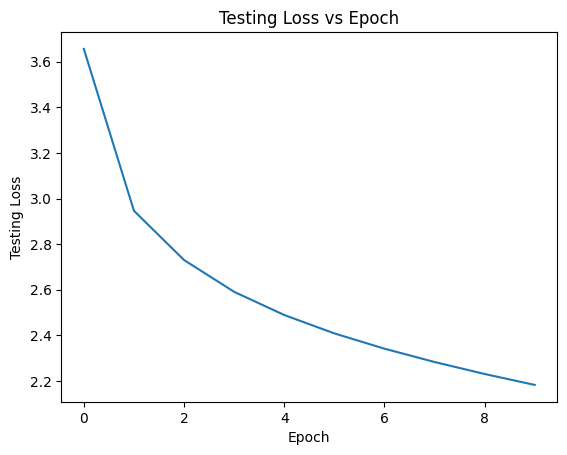

In [26]:
plt.title('Testing Loss vs Epoch')
plt.plot(train_loss)
plt.xlabel("Epoch")
plt.ylabel("Testing Loss")

# Model Testing

In [28]:
encoder = torch.load('encoder_gru_exp.pt')
decoder = torch.load('decoder_gru_exp.pt')

In [29]:
vocab = pickle.load(open('vocab.p', 'rb'))

In [30]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [31]:
test_transform = transforms.Compose([
            transforms.CenterCrop(crop_size),
            transforms.ToTensor(),
            transforms.Normalize((0.444, 0.421, 0.385),
                                 (0.285, 0.277, 0.286))])

test_loader = torch.utils.data.DataLoader(
            dataset=Custom_Flickr30k('flickr30k-images','results_20130124.token', vocab, transform=test_transform, train=False, test=True),
            batch_size=16,
            shuffle=True,
            num_workers=2,
            collate_fn=collate_fn)

In [36]:
encoder.to(device)
decoder.to(device)
for i,(images, captions, lengths) in enumerate(test_loader):
    if i>0: break
    features = encoder(images.to(device))
    imgs = images
    caps = captions
    results = decoder.sample(features)
    true_outputs=[]

    for caption in captions:
        caption = caption.cpu().numpy().astype(str).tolist()
        idx = 0
        curr_img_captions = [[]] 
        for tok in caption[1:-1]:
            if tok == '4': 
                idx += 1
                curr_img_captions.append([])
            elif tok != '0':
                curr_img_captions[idx].append(vocab.idx2word[int(tok)])
        true_outputs.append(curr_img_captions)

    predictions = []
    for pred in results:
        curr = []
        for tok in pred:
            if tok == '2':
                break
            curr.append(vocab.idx2word[int(tok)])
        predicted_caption = []
        for token_index in curr:
            if token_index == '<end>':
                break
            elif token_index == '<start>':
                continue
            predicted_caption.append(token_index)
        predictions.append(predicted_caption)
    print(nltk.bleu_score.corpus_bleu(true_outputs, predictions, weights=(1, 0, 0, 0)))    
    

0.259538022499849


a woman is sitting at a table with a drink and a man in a black shirt


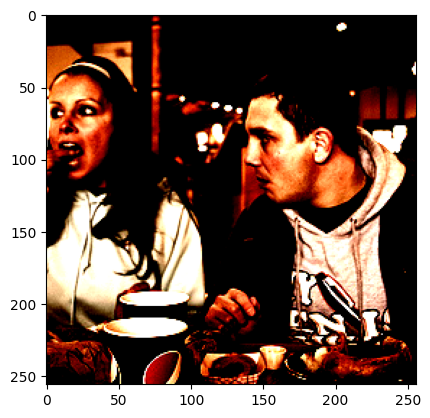

In [52]:
img = np.transpose(imgs[3], (1, 2, 0))
plt.imshow(img)
print(' '.join(str(word) for word in predictions[3]))

a man in a white shirt and black pants is riding a white horse


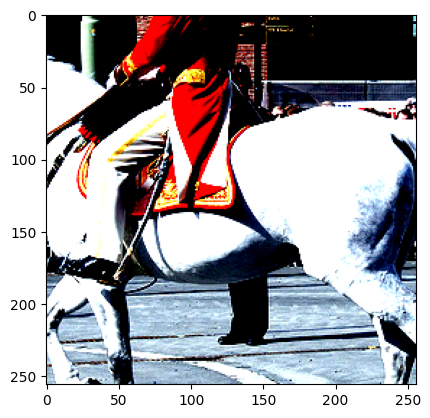

In [51]:
img = np.transpose(imgs[0], (1, 2, 0))
plt.imshow(img)
print(' '.join(str(word) for word in predictions[0]))

a man in a blue shirt is standing in front of a microphone


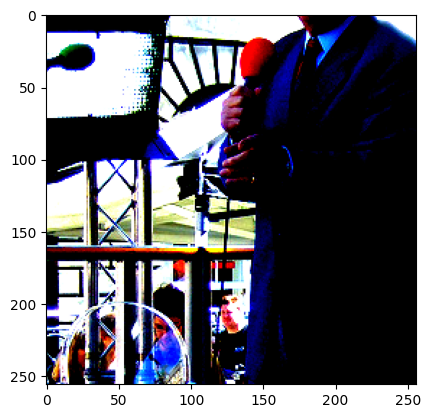

In [50]:
img = np.transpose(imgs[1], (1, 2, 0))
plt.imshow(img)
print(' '.join(str(word) for word in predictions[1]))

a group of people are running in a field


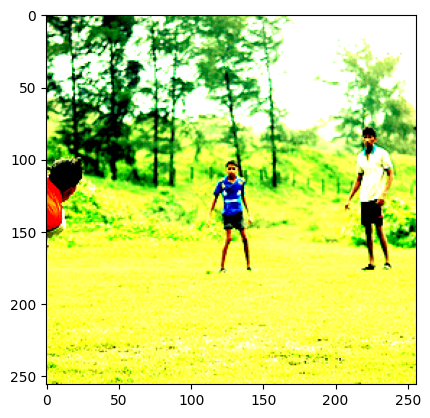

In [49]:
img = np.transpose(imgs[7], (1, 2, 0))
plt.imshow(img)
print(' '.join(str(word) for word in predictions[7]))

a skateboarder is doing a trick on a ramp


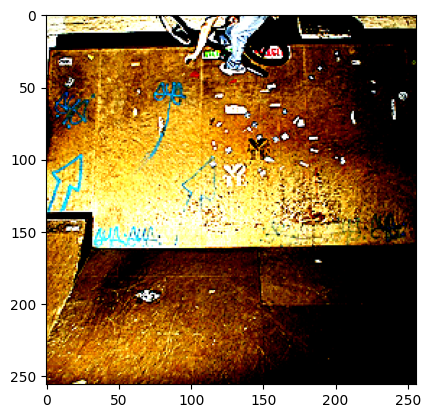

In [48]:
img = np.transpose(imgs[6], (1, 2, 0))
plt.imshow(img)
print(' '.join(str(word) for word in predictions[6]))